# Understanding `pycheops` using data of KELT-11 I: data download and visualisation

In the following notebook, we will play with CHEOPS data of KELT-11 data with an intention to understand various functionalities of `pycheops`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import juliet
import pycheops
from dace.cheops import Cheops

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Using DACE

In [3]:
data = Cheops.query_database()

# Name of the target
data['obj_id_catname']

['Pollux',
 'KELT-11b',
 'HD88111',
 'TYC5502-1037-1',
 'Fomalhaut',
 'HD88111',
 'Pollux',
 'Fomalhaut',
 'TESS_260647166',
 'TESS_260647166',
 'Altair',
 'KELT-11b',
 'TYC5502-1037-1',
 'Altair']

In [4]:
# To print the keys of dictinary
data.keys()

dict_keys(['obj_id_catname', 'obj_pos_coordinates_hms_dms', 'date_mjd_start', 'date_mjd_end', 'obj_mag_v', 'pi_name', 'prog_id', 'req_id', 'data_arch_rev', 'status_published', 'obs_exptime', 'photom_ap_radius', 'obs_id', 'data_pipe_version', 'photom_ap_type', 'pi_uid', 'prog_type', 'obj_mag_cheops', 'obj_mag_cheops_err', 'obj_sptype', 'obs_nexp', 'photom_lc_dataname', 'obs_total_exptime', 'data_proc_num', 'db_lc_available', 'file_rootpath', 'file_ext', 'ins_name', 'file_key', 'obj_mag_v_err'])

One can use `filter` keyword in `query_database` to query specific options from the database. For example, if I want to find all the object observed by KELT, I would try to find keyword 'KELT' in `obj_id_catname` - that is the name of the objects in the database (see below).

In [5]:
# Filters
fltr = {'obj_id_catname': {'contains':'KELT', 'notContains':'WASP', 'empty':False}}
data = Cheops.query_database(filters=fltr)
data['obj_id_catname'], data['file_key']

(['KELT-11b', 'KELT-11b'],
 ['CH_PR300024_TG000101_V0200', 'CH_PR300024_TG000101_V0101'])

The filter worked! We only got those objects in database which are observed by 'KELT' survey. Along with their names we printed the so-called `file_key` of the data. This is important keyword --- because this is what we essentially need while downloading data-products.

Note that there are two different file keys for the same object. We would think that this is because they have observed the same target twice. But this is not the case --- we can plot the lightcurves from these two files and check this detail, which we do below.

In [6]:
# To download the lightcurve
target_lc = Cheops.get_lightcurve(target='KELT-11b', aperture='Optimal')
# Note that one can also download full images from the Dace using the following command
# Cheops.download(file_type='images', filters=fltr, output_directory=os.getcwd())
# But keep in mind that this will download all (literally all) data available for the given target(s).
# This may take a while, and the file size may be large ~1.5GB.

# This command would give a dictionary containing data
# Its keys are,
target_lc.keys()

dict_keys(['photom_flux_vect_err', 'obj_date_bjd_vect', 'photom_conta_lc_vect_err', 'photom_centroid_x_vect', 'photom_centroid_y_vect', 'photom_roll_angle_vect', 'photom_background_vect', 'photom_conta_lc_vect', 'photom_flux_vect', 'file_key'])

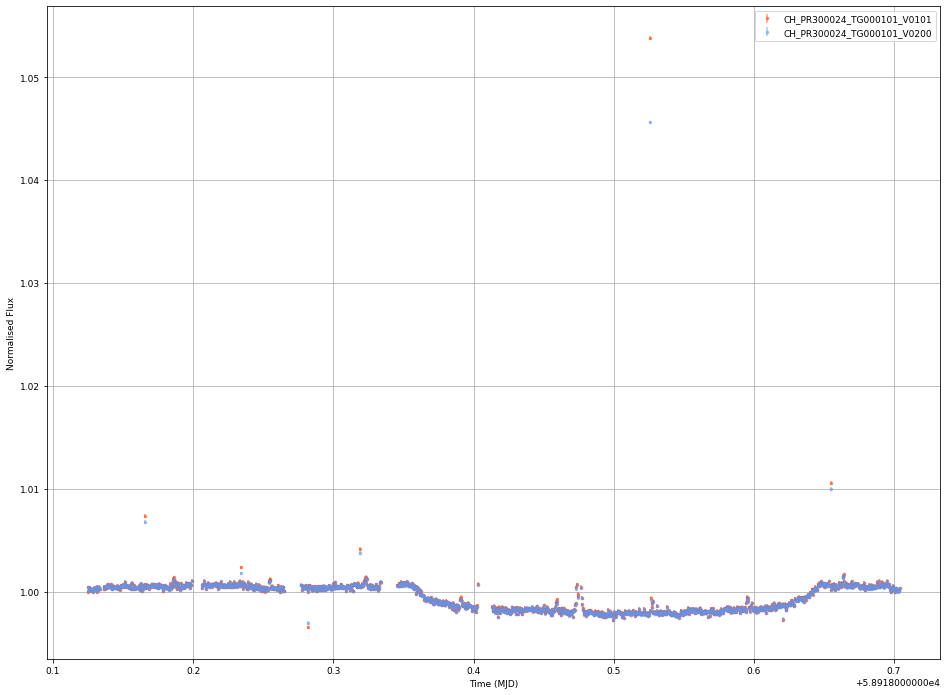

In [15]:
# Accessing the data from the dictionary and plotting it
tim1, tim2, fl1, fl2, fle1, fle2 = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
for i in range(len(target_lc['file_key'])):
    if target_lc['file_key'][i] == 'CH_PR300024_TG000101_V0101':
        tim1, fl1, fle1 = np.hstack((tim1, target_lc['obj_date_bjd_vect'][i])), np.hstack((fl1, target_lc['photom_flux_vect'][i])),\
             np.hstack((fle1, target_lc['photom_flux_vect_err'][i]))
    else:
        tim2, fl2, fle2 = np.hstack((tim2, target_lc['obj_date_bjd_vect'][i])), np.hstack((fl2, target_lc['photom_flux_vect'][i])),\
             np.hstack((fle2, target_lc['photom_flux_vect_err'][i]))

# Plotting the data
plt.figure(figsize=(16,12))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.', c='orangered', alpha=0.5, label='CH_PR300024_TG000101_V0101')
plt.errorbar(tim2, fl2, yerr=fle2, fmt='.', c='cornflowerblue', alpha=0.5, label='CH_PR300024_TG000101_V0200')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalised Flux')
plt.legend()
plt.grid()

We can zoom on the actual lightcurve to see the difference between both lightcurves (that is, for the sake of a better visualisation, we omit outliers).

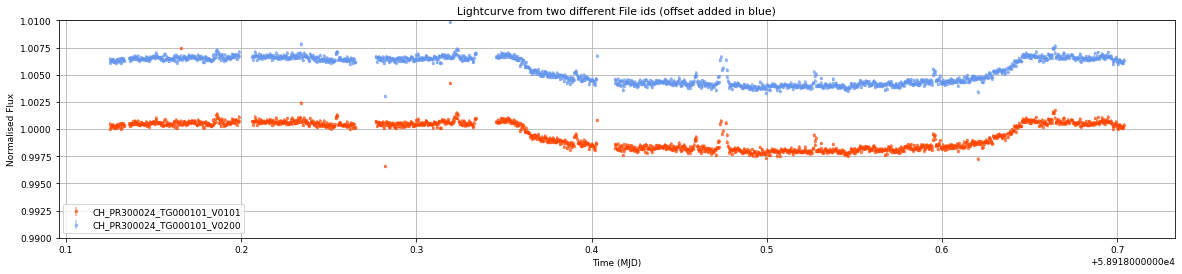

In [13]:
plt.figure(figsize=(20,4))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.', c='orangered', alpha=0.5, label='CH_PR300024_TG000101_V0101')
plt.errorbar(tim2, fl2+0.006, yerr=fle2, fmt='.', c='cornflowerblue', alpha=0.5, label='CH_PR300024_TG000101_V0200')
plt.xlabel('Time (MJD)')
plt.ylabel('Normalised Flux')
plt.legend()
plt.ylim([0.99,1.01])
plt.title('Lightcurve from two different File ids (offset added in blue)')
plt.grid()

It is now clear that both lightcurves are not of different observations (they have the same time). But, in fact, they produced from different version of data reduction pipelines. Since the file id ending with `..._V0200` indicates the usage of a later version of pipeline, we shall use that file id only in our analysis.

## Using `pycheops`

Now, we shall demonstrate the usage of `pycheops` in downloading and visualising the data.

In [16]:
# Downloading the data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')

2021-10-19 14:49:19,266 - INFO - Downloading file on location : /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz


 Download : 802 MB

2021-10-19 15:12:18,333 - INFO - File downloaded on location : /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz



Download done
Creating dataset file list
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Extracting report from .tgz file ...
